# Regression Model for Metro Interstate Traffic Volume Using Python Take 1
### David Lowe
### August 16, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Metro Interstate Traffic Volume dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: This dataset captured the hourly measurement of Interstate 94 Westbound traffic volume for MN DoT ATR station 301. The station is roughly midway between Minneapolis and St Paul, MN. The dataset also included the hourly weather and holiday attributes for assessing their impacts on traffic volume.

In this iteration, we will establish the baseline mean squared error for comparison with future rounds of modeling. This round of modeling will not include the date-time and weather description attributes.

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average RMSE of 2646. Two algorithms (k-Nearest Neighbors and Gradient Boosting) achieved the top RMSE metrics after the first round of modeling. After a series of tuning trials, Gradient Boosting turned in the top overall result and achieved an RMSE metric of 1887. By using the optimized parameters, the Gradient Boosting algorithm processed the test dataset with an RMSE of 1878, which was even better than the prediction from the training data.

CONCLUSION: For this iteration, the Gradient Boosting algorithm achieved the best overall results using the training and testing datasets. For this dataset, Gradient Boosting should be considered for further modeling.

Dataset Used: Metro Interstate Traffic Volume Data Set

Dataset ML Model: Regression with numerical and categorical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

One potential source of performance benchmarks: https://www.kaggle.com/ramyahr/metro-interstate-traffic-volume

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Environment

### 1.a) Load libraries and modules

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
import re
from datetime import datetime
from email.message import EmailMessage
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

### 1.b) Set up the controlling parameters and functions

In [28]:
# Create the random seed number for reproducible results
seedNum = 888

# Set up the number of CPU cores available for multi-thread processing
cpu_num = 6

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

In [29]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'neg_mean_squared_error'

In [30]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [31]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [32]:
startTimeScript = datetime.now()

dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'
# dest_file = os.path.basename(dataset_path)
dest_file = "Metro_Interstate_Traffic_Volume.csv"
if (os.path.isfile(dest_file) == False) :
    print('Downloading ' + dataset_path + ' as ' + dest_file)
    with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
        shutil.copyfileobj(in_resp, out_file)
    print(dest_file + 'downloaded!')
    print('Unpacking ' + dest_file)
    with zipfile.ZipFile(dest_file, 'r') as zip_ref:
        zip_ref.extractall('.')
    print(dest_file + 'unpacked!')

inputFile = dest_file
Xy_original = pd.read_csv(inputFile, sep=',', index_col=False)

In [33]:
# Take a peek at the dataframe after the import
Xy_original.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
5,None,291.72,0.0,0.0,1,Clear,sky is clear,2012-10-02 14:00:00,5181
6,None,293.17,0.0,0.0,1,Clear,sky is clear,2012-10-02 15:00:00,5584
7,None,293.86,0.0,0.0,1,Clear,sky is clear,2012-10-02 16:00:00,6015
8,None,294.14,0.0,0.0,20,Clouds,few clouds,2012-10-02 17:00:00,5791
9,None,293.10,0.0,0.0,20,Clouds,few clouds,2012-10-02 18:00:00,4770


In [34]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null object
traffic_volume         48204 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [35]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [36]:
# Convert columns from one data type to another
Xy_original['holiday'] = Xy_original['holiday'].astype('category')
Xy_original['weather_main'] = Xy_original['weather_main'].astype('category')

# Dropping features
Xy_original.drop(columns=['date_time', 'weather_description'], inplace=True)

In [37]:
# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,5545
1,None,289.36,0.0,0.0,75,Clouds,4516
2,None,289.58,0.0,0.0,90,Clouds,4767
3,None,290.13,0.0,0.0,90,Clouds,5026
4,None,291.14,0.0,0.0,75,Clouds,4918
5,None,291.72,0.0,0.0,1,Clear,5181
6,None,293.17,0.0,0.0,1,Clear,5584
7,None,293.86,0.0,0.0,1,Clear,6015
8,None,294.14,0.0,0.0,20,Clouds,5791
9,None,293.10,0.0,0.0,20,Clouds,4770


In [38]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 7 columns):
holiday           48204 non-null category
temp              48204 non-null float64
rain_1h           48204 non-null float64
snow_1h           48204 non-null float64
clouds_all        48204 non-null int64
weather_main      48204 non-null category
traffic_volume    48204 non-null int64
dtypes: category(2), float64(3), int64(2)
memory usage: 1.9 MB


In [39]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

holiday           0
temp              0
rain_1h           0
snow_1h           0
clouds_all        0
weather_main      0
traffic_volume    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [40]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [41]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'MEDV': 'targetVar'})

In [42]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (48204, 7) X_original.shape: (48204, 6) y_original.shape: (48204,)


### 1.f) Set up the parameters for data visualization

In [43]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [44]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [45]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [46]:
X_original.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main
0,None,288.28,0.0,0.0,40,Clouds
1,None,289.36,0.0,0.0,75,Clouds
2,None,289.58,0.0,0.0,90,Clouds
3,None,290.13,0.0,0.0,90,Clouds
4,None,291.14,0.0,0.0,75,Clouds
5,None,291.72,0.0,0.0,1,Clear
6,None,293.17,0.0,0.0,1,Clear
7,None,293.86,0.0,0.0,1,Clear
8,None,294.14,0.0,0.0,20,Clouds
9,None,293.10,0.0,0.0,20,Clouds


#### 2.a.ii) Dimensions and attribute types

In [47]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 6 columns):
holiday         48204 non-null category
temp            48204 non-null float64
rain_1h         48204 non-null float64
snow_1h         48204 non-null float64
clouds_all      48204 non-null int64
weather_main    48204 non-null category
dtypes: category(2), float64(3), int64(1)
memory usage: 1.6 MB


#### 2.a.iii) Statistical summary of the attributes

In [48]:
X_original.describe()

,temp,rain_1h,snow_1h,clouds_all
count,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231
std,13.338232,44.789133,0.008168,39.015750
min,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000
50%,282.450000,0.000000,0.000000,64.000000
75%,291.806000,0.000000,0.000000,90.000000
max,310.070000,9831.300000,0.510000,100.000000


### 2.b) Data Visualization

##### 2.b.i) Univariate plots to better understand each attribute

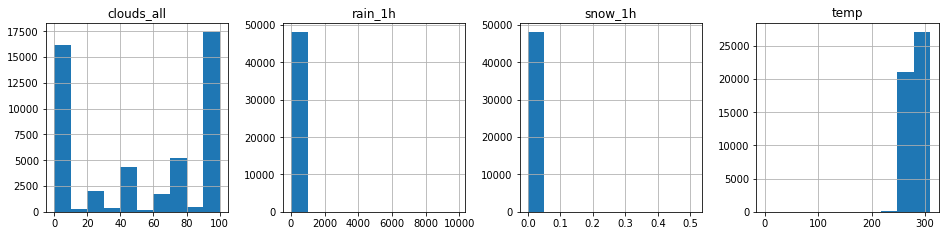

In [49]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

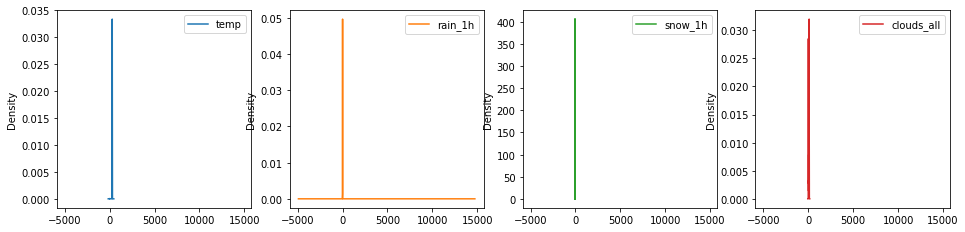

In [50]:
# Density plot for each attribute
X_original.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
plt.show()

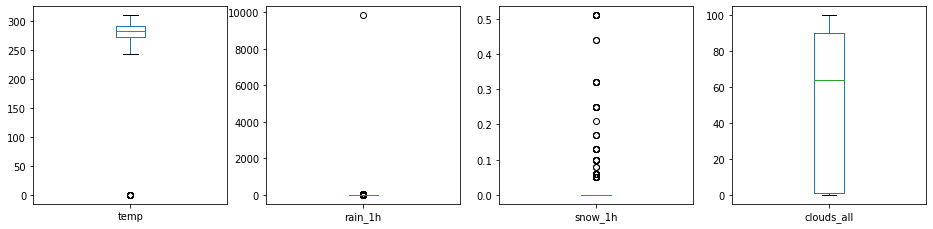

In [51]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [52]:
# Scatterplot matrix
# scatter_matrix(X_original)
# plt.show()

In [53]:
# Correlation matrix
# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111)
# correlations = X_original.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

In [54]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [55]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [56]:
# Sample code for performing one-hot-encoding before splitting into trainig and test

X_original = pd.get_dummies(X_original)
print(X_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 27 columns):
temp                                 48204 non-null float64
rain_1h                              48204 non-null float64
snow_1h                              48204 non-null float64
clouds_all                           48204 non-null int64
holiday_Christmas Day                48204 non-null uint8
holiday_Columbus Day                 48204 non-null uint8
holiday_Independence Day             48204 non-null uint8
holiday_Labor Day                    48204 non-null uint8
holiday_Martin Luther King Jr Day    48204 non-null uint8
holiday_Memorial Day                 48204 non-null uint8
holiday_New Years Day                48204 non-null uint8
holiday_None                         48204 non-null uint8
holiday_State Fair                   48204 non-null uint8
holiday_Thanksgiving Day             48204 non-null uint8
holiday_Veterans Day                 48204 non-null uint8
holiday_Washing

In [57]:
# Use 75% of the data to train the models and the remaining for testing/validation

testDataset_size = 0.25
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=testDataset_size, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (36153, 27) y_train_df.shape: (36153,)
X_test_df.shape: (12051, 27) y_test_df.shape: (12051,)


### 3.b) Feature Selection

In [58]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [59]:
# We finalize the training and testing datasets for the modeling activities
X_train = X_train_df.values
y_train = y_train_df.values
X_test = X_test_df.values
y_test = y_test_df.values
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (36153, 27) y_train.shape: (36153,)
X_test.shape: (12051, 27) y_test.shape: (12051,)


In [60]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate four linear, two non-linear, and four ensemble algorithms:

Linear Algorithms: Linear Regression, Ridge Regression, LASSO Regression, and Elastic Net Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [61]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
models = []
models.append(('LR', LinearRegression(n_jobs=cpu_num)))
models.append(('RR', Ridge(random_state=seedNum)))
models.append(('LASSO', Lasso(random_state=seedNum)))
models.append(('EN', ElasticNet(random_state=seedNum)))
models.append(('CART', DecisionTreeRegressor(random_state=seedNum)))
models.append(('KNN', KNeighborsRegressor(n_jobs=cpu_num)))
models.append(('RF', RandomForestRegressor(random_state=seedNum, n_jobs=cpu_num)))
models.append(('ET', ExtraTreesRegressor(random_state=seedNum, n_jobs=cpu_num)))
models.append(('GBM', GradientBoostingRegressor(random_state=seedNum)))
# models.append(('XGB', XGBRegressor(random_state=seedNum, n_jobs=cpu_num)))
results = []
names = []
metrics = []

In [62]:
# Generate model in turn
for name, model in models:
	if (notifyStatus): email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	if (notifyStatus): email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average RMSE from all models:',math.sqrt(np.mean(metrics)*-1.0))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

LR: -9834121.370783 (18136922.004197)
Model training time: 0:00:01.288703
RR: -9831433.305116 (18129042.255977)
Model training time: 0:00:00.111698
LASSO: -10005101.622173 (18648925.958558)
Model training time: 0:00:00.254903
EN: -10168895.654921 (19008229.653411)
Model training time: 0:00:00.135947
CART: -5698197.834697 (165189.755190)
Model training time: 0:00:01.841169
KNN: -4170458.940628 (119154.671326)
Model training time: 0:00:23.587471
RF: -4461614.167663 (130322.135104)
Model training time: 0:00:06.066514
ET: -5226221.763405 (127570.332813)
Model training time: 0:00:07.533546
GBM: -3631706.507244 (52748.810249)
Model training time: 0:00:23.151526
Average RMSE from all models: 2646.333966633672
Total training time for all models: 0:00:23.152162


### 4.b) Spot-checking baseline algorithms

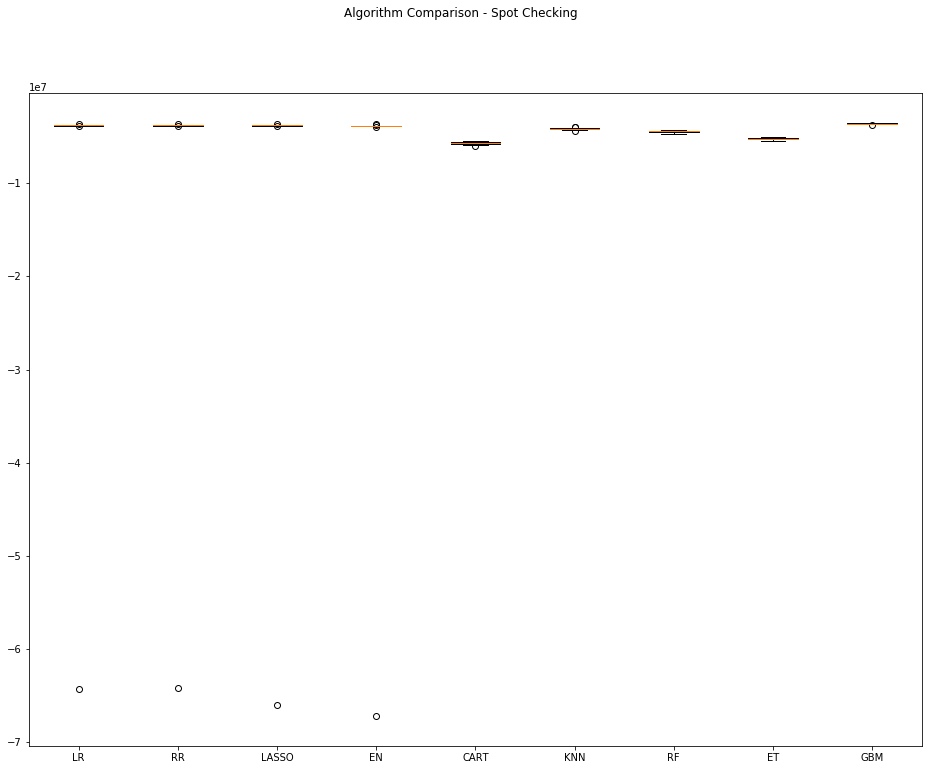

In [63]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [64]:
# Set up the comparison array
results = []
names = []

In [65]:
# Tuning algorithm #1 - k-Nearest Neighbors
if (notifyStatus): email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict(n_neighbors=np.array([5, 25, 50, 75, 100]))
model1 = KNeighborsRegressor(n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('KNN')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result1.best_score_*-1)))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: -3650366.338648 using {'n_neighbors': 100}
-4170448.665284 (119156.967097) with: {'n_neighbors': 5}
-3687049.274795 (58606.202094) with: {'n_neighbors': 25}
-3662172.659494 (62383.182899) with: {'n_neighbors': 50}
-3652708.346944 (58485.860084) with: {'n_neighbors': 75}
-3650366.338648 (56812.709526) with: {'n_neighbors': 100}
Best RMSE for the Model is: 1910.5931902547952
Model training time: 0:01:19.566444


In [66]:
# Tuning algorithm #2 - Gradient Boosting
if (notifyStatus): email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([200, 400, 600, 800, 1000]))
model2 = GradientBoostingRegressor(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('GBM')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result2.best_score_*-1)))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: -3564349.250520 using {'n_estimators': 1000}
-3606592.410076 (53730.567739) with: {'n_estimators': 200}
-3581484.900612 (55735.959568) with: {'n_estimators': 400}
-3572862.316290 (57903.744548) with: {'n_estimators': 600}
-3567937.325384 (59197.892627) with: {'n_estimators': 800}
-3564349.250520 (61437.682167) with: {'n_estimators': 1000}
Best RMSE for the Model is: 1887.9484236916971
Model training time: 0:11:40.859346


### 5.b) Compare Algorithms After Tuning

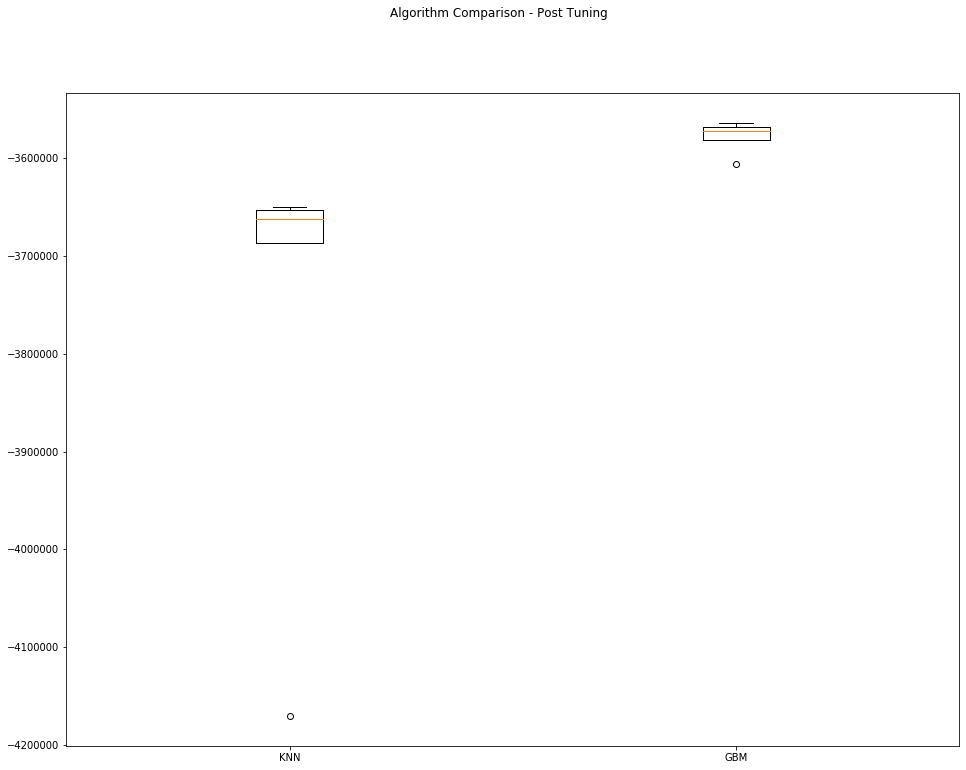

In [67]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [68]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [69]:
model = KNeighborsRegressor(n_neighbors=100)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('RMSE for the model is: ', math.sqrt(mean_squared_error(y_test, predictions)))
print('R2 for the model is: ', r2_score(y_test, predictions))

RMSE for the model is:  1910.1681783063495
R2 for the model is:  0.07805979040868727


In [70]:
model = GradientBoostingRegressor(n_estimators=1000, random_state=seedNum)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('RMSE for the model is: ', math.sqrt(mean_squared_error(y_test, predictions)))
print('R2 for the model is: ', r2_score(y_test, predictions))

RMSE for the model is:  1878.7728556445913
R2 for the model is:  0.10811656279121928


### 6.b) Create a standalone model using all available data

In [71]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_test))
y_complete = np.concatenate((y_train, y_test))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))

finalModel = GradientBoostingRegressor(n_estimators=1000, random_state=seedNum)
# finalModel.fit(X_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

X_complete.shape: (48204, 27) y_complete.shape: (48204,)
Model training time: 0:00:00.004911


### 6.c) Save the final model for later use

In [72]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [73]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [74]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:14:40.189604
